# Tasks 2 and 3 : DMTS with passive distractors

This notebooks implements the taks 2 and 3 of the working memory project.

In this case, a sample and test images are presented at the beggining and end of a sequence of images. The images in between, known as delay images, can be either black images or the so-called "passive distractors", i.e. other images of the dataset.

In task 2, we need to build a model able to determine if a sequence presents repeated sample and test images. In task 3, on top of that, we need to determine the model class of every image in between.

In [3]:
# import os
# os.chdir('..')
os.getcwd()

'/Users/angelglh/Documents/github_angelglh/working_memory'

In [21]:
import os
import numpy as np
from array import array
import matplotlib.pyplot as plt
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

from sklearn.metrics import accuracy_score

# Custom functions and modules
from src.utils.process_images import *
from src.utils.metrics import * 
from src.data_funs.task_loading import *
from src.data_funs.task_visualizing import *
from src.models import ConvLSTMClassifier

In [26]:
# Reload the packages
importlib.reload(src.utils.process_images)
importlib.reload(src.utils.metrics)
importlib.reload(src.data_funs.task_loading)
importlib.reload(src.data_funs.task_visualizing)
importlib.reload(src.models)

<module 'src.models' from '/Users/angelglh/Documents/github_angelglh/working_memory/src/models.py'>

## 1. Loading and visualizing the data

In [16]:
raw_MNIST = os.getcwd() + '/data/MNIST/raw'
delay_images = 5

# Training data
training_MNIST = tasks2and3_Dataset_MNIST(is_train_data = True, 
                                     delay_length=delay_images,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/train-images-idx3-ubyte', raw_MNIST + '/train-labels-idx1-ubyte')
                    )

training_loader_MNIST = DataLoader(training_MNIST, batch_size=64, shuffle=True)


# Training and validation data

testing_all_MNIST = tasks2and3_Dataset_MNIST(is_train_data = False, 
                                     delay_length=delay_images,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/t10k-images-idx3-ubyte', raw_MNIST + '/t10k-labels-idx1-ubyte')
                    )

test_size = len(testing_all_MNIST) //2
testing_MNIST, valid_MNIST = random_split(testing_all_MNIST, [test_size, len(testing_all_MNIST) - test_size])

testing_loader_MNIST = DataLoader(testing_MNIST, batch_size=64, shuffle=True)
valid_loader_MNIST = DataLoader(valid_MNIST, batch_size=64, shuffle=True)


Training data ...


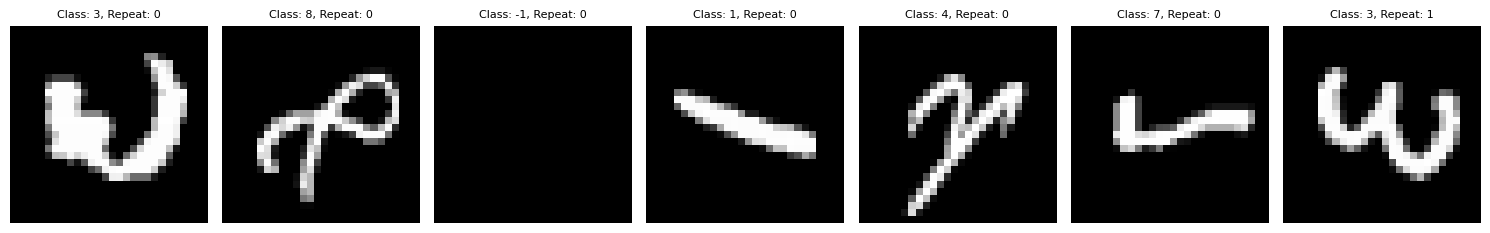

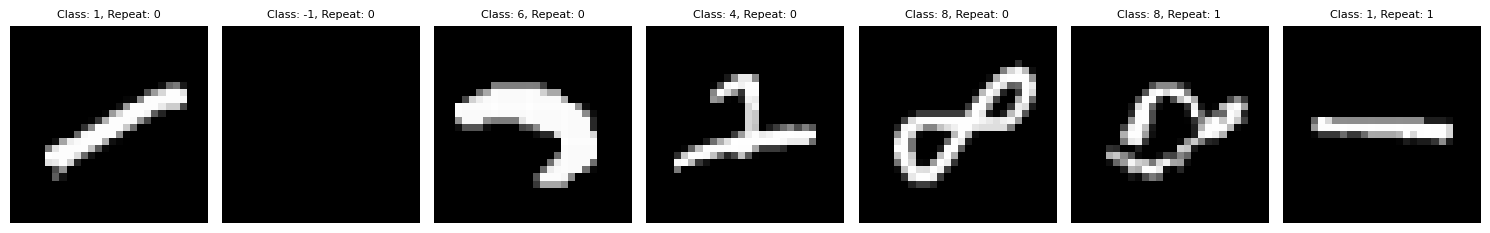


Testing data ...


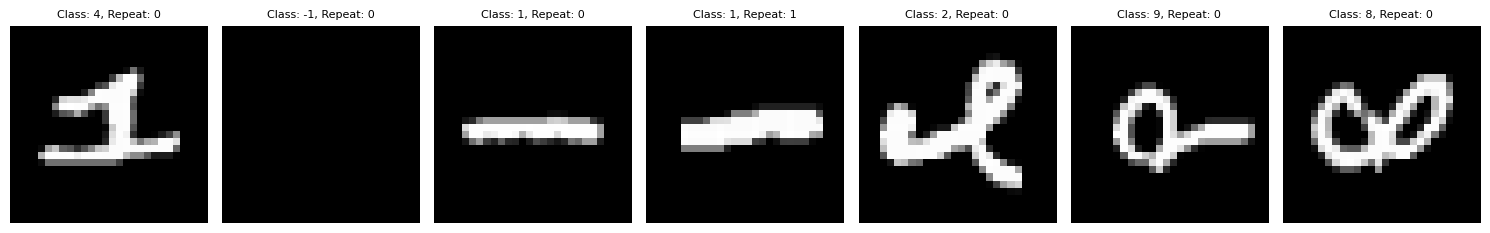

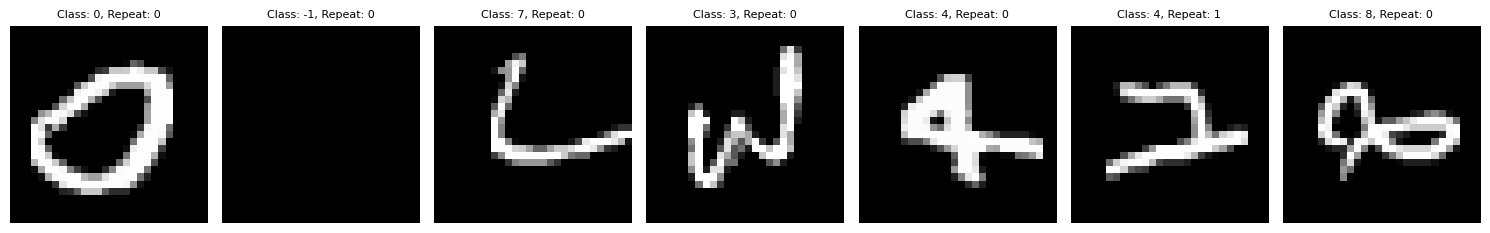


Validation data ...


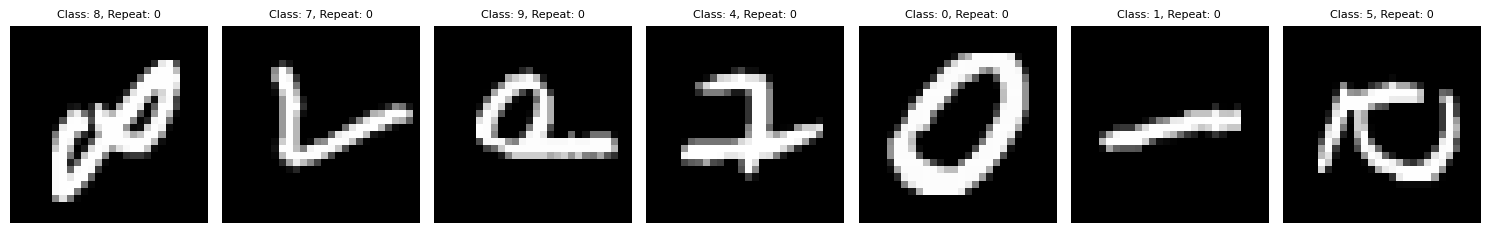

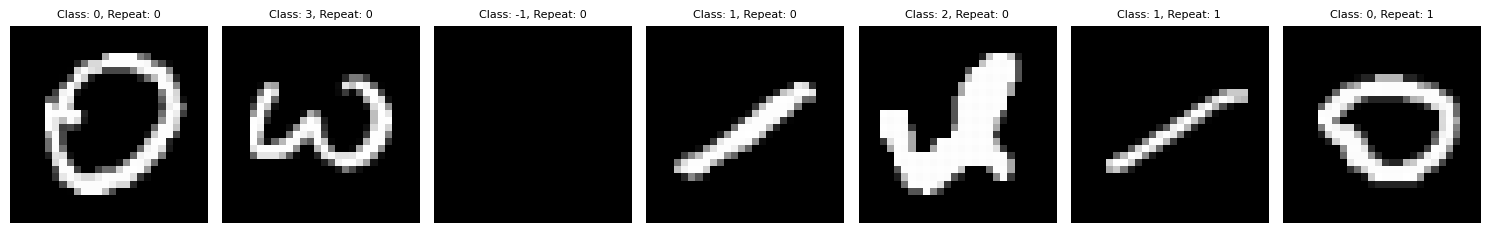

In [17]:
n_images_to_show = 2

# Visualize training, test and validation data
print("\nTraining data ...")
for sequences, class_labels, repeat_labels, match_labels in training_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nTesting data ...")
for sequences, class_labels, repeat_labels, match_labels in testing_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nValidation data ...")
for sequences, class_labels, repeat_labels, match_labels in  valid_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

## 2. Train a model able to detect images repetition as well as model classes within the sequence

Two-staged model : 
1. Needs to determine the model class of every image of the sequence
2. Needs to determine if there is a repetition between sample and test images 

## 3. Model evaluation

In [23]:
## Let us address model trained on task one to be a good 
models_directory = os.getcwd() + "/models"

# initialize the model as in task 1
ignore_class = -1

input_dim = 1  # Grey images present only 1 channel
hidden_dim = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers
num_classes = 10 # Number of classes 

model_pretrained_task1 = ConvLSTMClassifier(input_dim, hidden_dim, num_layers, num_classes)

# Load the pretrained weights and biases
model_pretrained_task1.load_staate_dict(torch.load(models_directory + "/model_task1_MNIST_classes.pt"))

model_pretrained_task1.eval()

ConvLSTMClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(3136, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
individual_accuracy, sequence_accuracy = accuracy_of_class_labels(model = model_pretrained_task1, 
                                                                  valid_loader= valid_loader_MNIST, 
                                                                  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
                                                                  noise_image_class = -1)

print(f'Individual Image Accuracy: {individual_accuracy * 100:.2f}%')
print(f'Whole Sequence Accuracy: {sequence_accuracy * 100:.2f}%')

Individual Image Accuracy: 95.71%
Whole Sequence Accuracy: 77.14%
